# Product Propensity : Measuring Performance
* StelllarAlgo Data Science
* Ryan Kazmerik & Peter Morrison
* Feb 6, 2023

This notebook attempts to measure the performance of our Product Propensity model scores by comparing each quartile of scores to see how many fans actually purchased a higher package

In [65]:
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from data_sci_toolkit.aws_tools import permission_tools 
from data_sci_toolkit.aws_tools import redshift_tools
from data_sci_toolkit.common_tools import config_tools

In [66]:
session = permission_tools.get_aws_session("US-StellarSupport")

Authorized as AROAUSMVSGV62RMB5U6S5:rkazmerik@stellaralgo.com


In [77]:
# Set team to be scored
SUBTYPE = "NHL-Flames"
params = config_tools.get_team_config(SUBTYPE, True)

### Let's load up a list of PP scores for a date from S3:

In [78]:
S3_PATH = "s3://us-curated-data-sci-product-propensity-us-east-1-d2n55o/product-propensity-scores/date=2023-02-22/flames/"
# S3_PATH = "s3://us-curated-data-sci-product-propensity-us-east-1-d2n55o/product-propensity-scores/date=2022-11-30/flames/"


In [124]:
df_scores = wr.s3.read_csv(boto3_session=session, path=S3_PATH, path_suffix=[".csv"])
df_scores["sascore"] = df_scores["sascore"]*100
df_scores.shape

(2188, 29)

In [125]:
df_scores.groupby(["product","product_current"]).agg({
    "product":"count"
})

product
product     product_current         
Any         Individual          2000
Full Season Flex Plan             55
            Half Season           34
            Mini Plan             53
Half Season Flex Plan              7
            Mini Plan             10
Mini Plan   Flex Plan             29

### Let's visualize the distrubution of scores:

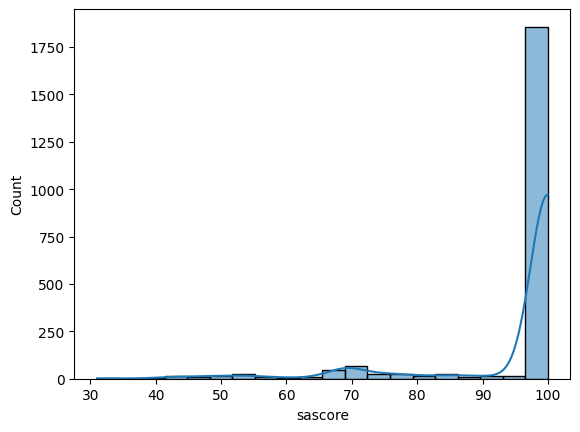

In [126]:
sns.histplot(data=df_scores, x='sascore', bins=20, kde=True);

### Now let's grab a list of customers that have renewed their product for the 2023 season:

In [127]:
CLUSTER = "prod-app"
DATABASE = "stlrflames"

In [128]:
conn = redshift_tools.get_redshift_connection(CLUSTER, DATABASE)

cur = conn.cursor()
cur.execute(f"""
    SELECT cc.dimcustomermasterid, cp.productgrouping as product
    FROM {DATABASE}.dw.cohortpurchase cp
    RIGHT JOIN dw.cohortcustomer cc
    ON cp.dimcustomermasterid = cc.dimcustomermasterid 
    WHERE seasonyear = 2023
    AND productgrouping IN ('Full Season', 'Half Season', 'Mini Plan', 'Flex Plan')
    GROUP BY cc.dimcustomermasterid, cp.productgrouping
""")

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df_purchase = pd.DataFrame(data=data, columns=cols)

conn.commit()
conn.close()
df_purchase.shape


Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(6290, 2)

In [129]:
df_purchase.groupby(["product"]).agg({
    "product":"count"
})

,product
product,
Flex Plan,210
Full Season,4850
Half Season,564
Mini Plan,666


In [130]:
df_join = df_scores.merge(df_purchase, on="dimcustomermasterid", how="inner")
df_join.shape

(13, 30)

In [131]:
df_join.groupby(["product_x","product_y"]).agg({
    "product_x":"count"
})

product_x
product_x   product_y             
Any         Flex Plan            5
            Full Season          1
            Half Season          1
            Mini Plan            1
Full Season Flex Plan            3
Half Season Flex Plan            1
            Half Season          1

<AxesSubplot:xlabel='sascore', ylabel='Count'>

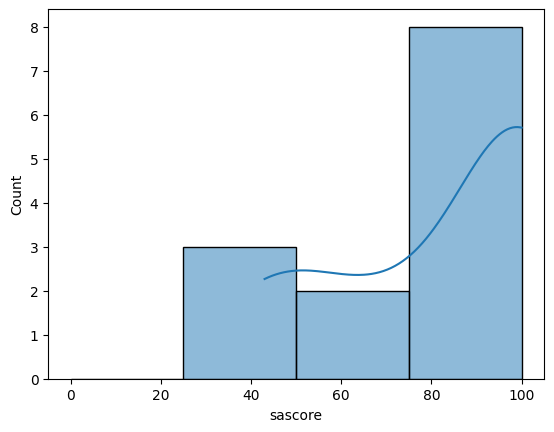

In [133]:
sns.histplot(data=df_join, x='sascore', bins=[0,25,50,75,100], kde=True)

In [136]:
# Create quartiles
df_scores['quartile'] = pd.cut(df_scores['sascore'], [0, 25, 50, 75, 100], labels = ["0-25", "26-50", "51-75", "76-100"])

df_scores['quartile']
merged_df

,atp_last,attendance_current,attended_last,attended_prior,clientcode,dimcustomermasterid,distance,events_current,events_last,events_prior,lkupclientid,product_current,product_last,product,sascore,seasonyear,scoredate,spend_current,tenure,volume_current,sends,sends_prior,opens,opens_prior,date_last_send,date_last_touch,date_last_save,newflag,priority,quartile
0,77.39,0.222222,6,59,FLAMES,142143,18.82,18,34,216,36,Mini Plan,Full Season,Full Season,98.0,2022,2022-10-31 10:33:11,4522.28,7,42,0,0,2,0,NaN,NaN,NaN,1,0.98,76-100
1,0.00,0.000000,0,0,FLAMES,552158,3265.94,3,0,3,36,Flex Plan,None,Full Season,86.0,2022,2022-10-31 10:33:11,59.80,1,10,0,0,0,0,NaN,NaN,NaN,1,0.87,76-100
2,148.03,0.058824,0,114,FLAMES,523476,13.54,17,33,214,36,Mini Plan,Full Season,Full Season,82.0,2022,2022-10-31 10:33:11,2318.60,7,34,0,0,0,0,NaN,NaN,NaN,1,0.83,76-100
3,0.00,0.900000,0,9,FLAMES,259345,6.84,10,0,11,36,Flex Plan,None,Full Season,100.0,2022,2022-10-31 10:33:11,2472.94,5,26,42,41,6,2,2022-10-30,NaN,2022-10-18,0,0.69,76-100
4,0.00,0.750000,0,3,FLAMES,452084,30.14,4,0,4,36,Flex Plan,None,Full Season,100.0,2022,2022-10-31 10:33:11,29.90,1,8,39,29,20,46,2022-10-30,NaN,NaN,0,0.69,76-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,0.00,1.000000,1,5,FLAMES,339245,140.99,2,1,5,36,Individual,None,Any,100.0,2022,2022-10-31 10:33:11,1610.00,5,4,20,23,17,21,2022-10-29,NaN,2022-10-18,0,0.69,76-100
2184,0.00,0.000000,1,1,FLAMES,1907,210.86,1,1,2,36,Individual,None,Any,100.0,2022,2022-10-31 10:33:11,0.00,3,4,1,0,2,0,2022-10-07,NaN,2022-10-05,0,0.69,76-100
2185,0.00,0.333333,0,1,FLAMES,367049,13.54,3,0,3,36,Individual,None,Any,100.0,2022,2022-10-31 10:33:11,0.00,1,8,5,9,1,0,2022-10-03,NaN,2022-10-18,0,0.69,76-100
2186,0.00,0.785714,0,11,FLAMES,337827,2.06,14,0,14,36,Individual,None,Any,100.0,2022,2022-10-31 10:33:11,0.00,1,33,0,0,0,0,NaN,NaN,2022-10-18,0,0.69,76-100
